In [3]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import matplotlib
import seaborn as sns
import pandas as pd
from tueplots import bundles
from scipy.special import airy
import os
import tqdm

In [4]:
SimulationParameters = collections.namedtuple(
    "SimulationParameters",
    [
        "arrival_rate",
        "gen_length",
        "dt",
        "removal_thresh",
        "selection_thresh",
        "basl_prod_dsrna",
        "init_g0",
        "init_h0",
        "generation_offspring",
        "Vtot",
        "V_crit",
        "default_sigma"
    ],
)


CircuitParameters = collections.namedtuple(
    "CircuitParameters",
    [
        "V",
        "sigma",
        "gamma1",
        "gamma2",
        "k1",
        "k2",
        "k3",
        "nh",
        "psi",
    ],
)


sim_params = SimulationParameters(
    arrival_rate=20,
    gen_length=72,
    dt=0.1,
    removal_thresh= 0.2,
    selection_thresh = 3,
    basl_prod_dsrna=0.3,
    init_g0 = 3,
    init_h0 = 0,
    generation_offspring=250,
    Vtot = 200,
    V_crit=0.56,
    default_sigma=0.02
)

dsrna_production = lambda t: sim_params.basl_prod_dsrna if t < sim_params.gen_length else 0


def load_circuit_params(V=0.55,sigma=0.02,gamma1=0.1, gamma2=0.1,k1 = 2,k2 = 2,k3 = 0.1,psi = 0.1,nh=3):
    circuit_params = CircuitParameters(
        V=V,
        sigma=sigma,
        gamma1=gamma1,
        gamma2=gamma2,
        k1 = k1,
        k2 = k2,
        k3 = k3,
        nh=nh,
        psi = psi
    )
    return circuit_params



In [5]:
class Simulation(object):
    """
    This class can be used to simulate the TI / TIC models, including performing selection and estimating exit times distributions.
    Outputs as in the manuscript are generally evaluated against an input paramter V which is a control paramter in the TI model.
    Functions output a state vector and a history array of state vectors sampled during the simulation.
    @run_TI executes the TI model for a given number of generation.
    @run_TI_exit_times simulates the TI model and returns a list of times where individuals became de-silenced.
    @run_TIC executres the stochastic TIC model.
    @run_TI_selection includes selection by silencing levels.
    """
    def __init__(self):
        pass
    def initialize(N,V=None,sigma=None,v_std=0):
        genes = []
        for i in range(N):
            if type(V)==type(None):
                params = load_circuit_params()
            else:
                params = load_circuit_params(V=V,sigma=sigma)
            genes.append((sim_params.init_g0, sim_params.init_h0, 0.0,params.k1,params.k2,params.k3,params.nh,params.psi,params.V,params.gamma1,params.gamma2,params.sigma,np.random.normal(1,v_std)))
        return genes

    def name_initalized_genes(genes):
        return np.array(genes, dtype=[('g', 'float'), ('h', 'float'), ('t_excited', 'float'),
                                      ('k1','float'),('k2','float'),('k3','float'),('nh','float'),
                                      ('psi','float'),('V','float'),('gamma1','float'),('gamma2','float'),
                                      ('sigma','float'),("indivudality",'float')])


    # step functions
    def est_dg_dh(state,production=0):
        dt = sim_params.dt
        dg_det = production + state["indivudality"]*state["V"]*(np.power(state["g"],state["nh"])/(np.power(state["g"],state["nh"])+np.power(state["k1"],3)))*state["k2"]/(state["h"]+state["k2"]) - state["gamma1"]*state["g"]
        dh_det = state["psi"]*state["g"]/(state["k3"]+state["g"]) - state["gamma2"]*state["h"]
        dg_noise = state["sigma"]*state["g"]*np.random.normal(size=state["g"].shape[0])
        dh_noise = state["sigma"]*state["h"]*np.random.normal(size=state["h"].shape[0])

        dg = dt*dg_det+np.sqrt(dt)*dg_noise
        dh = dt*dh_det+np.sqrt(dt)*dh_noise
        return dg,dh

    def step(self,state,production,V):
        # here we don't use V
        dg,dh = Simulation.est_dg_dh(state,production)
        dV = 0
        return dg,dh,dV

    def step_TIC_V(self,state,Vtot):
        return Vtot/(state["g"].sum()+1) - state["V"]

    def est_silencing(state):
        return np.sqrt(state["g"]**2+state["h"]**2)

    def log_init(state):
        hist,_ = Simulation.log(-1,state)
        hist['t']=0
        return hist
    def log(t,state,hist=None):
        if (t==0) or (not (t%1 < 1e-9)) :
            return hist,None

        silencing = Simulation.est_silencing(state)
        silenced = (silencing > sim_params.removal_thresh).mean()
        
        vec = np.array((t,state["g"].mean(),state["h"].mean(),state["V"].mean(),state.shape[0],state["indivudality"].mean(),silenced), 
                       dtype=[('t', 'float'),('g', 'float'), ('h', 'float'),('V','float'),('M','float'),('individuality','float'),('silenced','float')])
        if type(hist)==type(None):
            hist = vec
        else:
            hist = np.append(hist,vec)

        return hist,vec

    def run_TI(self,gens,V,sigma=sim_params.default_sigma,N=1,g0=3,h0=0,
               condition_end=-1,production = lambda t: 0,save_hist=True,v_std=0):
        state = Simulation.name_initalized_genes(Simulation.initialize(N,V,sigma,v_std))
        state["g"] = g0
        state["h"] = h0
        hist = Simulation.log_init(state)
        t_=np.arange(0,sim_params.gen_length*gens,sim_params.dt)
        for t in t_:
            dg,dh,dV = self.step(state,production(t),V)
            state["g"] += dg
            state["h"] += dh
            state["V"] += dV
            if save_hist:
                hist,last = Simulation.log(t,state,hist)
            else:
                hist,last = Simulation.log(t,state)
            
            if not type(last)==type(None):
                if last["silenced"]<=condition_end:
                    break

        return state,hist,t

    def run_TI_exit_times(self,gens,V,sigma=sim_params.default_sigma,N=1000,g0=3,h0=0,v_std=0):
        state = Simulation.name_initalized_genes(Simulation.initialize(N,V,sigma,v_std))
        
        max_exit = sim_params.gen_length*gens
        exit_times = np.repeat(max_exit,N)
        state["g"] = g0
        state["h"] = h0
        hist = Simulation.log_init(state)
        t_=np.arange(0,sim_params.gen_length*gens,sim_params.dt)
        for t in t_:
            dg,dh,dV = self.step(state,0,V)
            state["g"] += dg
            state["h"] += dh
            state["V"] += dV
            silenced = Simulation.est_silencing(state) > sim_params.removal_thresh
            
            exit_times[(~silenced) & (exit_times==max_exit)] = t
            
            if (exit_times<max_exit).all():
                break

        return state,exit_times

    def run_TIC(self,gens,Vtot=sim_params.Vtot,sigma=sim_params.default_sigma,v_std=0,Vtot_scale=lambda t: 1):
        state = Simulation.name_initalized_genes(Simulation.initialize(1,V=Vtot,sigma=sigma,v_std=v_std))
        t_=np.arange(0,sim_params.gen_length*gens,sim_params.dt)
        hist = Simulation.log_init(state)
        silenced_durations = np.array([])
        for t in t_:
            dg,dh,dV = self.step(state,0,Vtot*Vtot_scale(t))
            state["g"] += dg
            state["h"] += dh
            dV = self.step_TIC_V(state,Vtot*Vtot_scale(t))
            state["V"] += dV
            state["t_excited"] += sim_params.dt
            hist,_ = Simulation.log(t,state,hist)

            # remove desilenced
            silencing = Simulation.est_silencing(state)
            idx = silencing > sim_params.removal_thresh
            if (~idx).any():
                silenced_durations = np.append(silenced_durations,(state[~idx]["t_excited"]))
                state = state[idx]

            if np.random.rand()<sim_params.dt*sim_params.arrival_rate / (sim_params.gen_length):
                state_B=Simulation.name_initalized_genes(Simulation.initialize(1,V=state["V"].mean(),sigma=sigma,v_std=v_std))
                state = np.append(state,state_B)

        return state,hist,t,silenced_durations
    
    def run_TI_selection(self,gens,V,sigma=sim_params.default_sigma,g0=3,h0=0,directed=False,
                         production = lambda t: 0,save_dists=True,condition_end=-1):
        state = Simulation.name_initalized_genes(Simulation.initialize(sim_params.generation_offspring,V,sigma))
        state["g"] = g0
        state["h"] = h0
        hist = Simulation.log_init(state)
        hist_dists = []
        t_=np.arange(0,sim_params.gen_length,sim_params.dt)
        for gen in range(gens):
            for t_inner in t_:
                t = gen*sim_params.gen_length+t_inner
                dg,dh,dV = self.step(state,production(t),V)
                state["g"] += dg
                state["h"] += dh
                state["V"] += dV
                hist,last = Simulation.log(t,state,hist)
                
                if not type(last)==type(None):
                    if last["silenced"]<=condition_end:
                        return state,hist,np.array(hist_dists),t


            silencing = Simulation.est_silencing(state)
            if directed:
                idx_opts = silencing>sim_params.selection_thresh
                if idx_opts.any():
                    idx = np.argwhere(idx_opts)[0]
                else:
                    idx = 0
            else:
                idx = 0
            if save_dists:
                hist_dists.append(silencing.copy())
            
            state["g"] = state["g"][idx]
            state["h"] = state["h"][idx]


        return state,hist,np.array(hist_dists),t

    
class SimulationDynamicV(Simulation):
    """
    A simulation instance where V is fluctuating.
    """
    def step(self,state,production,V,sigma_V=0.1):
        dg,dh = Simulation.est_dg_dh(state,production)
        dV = (V-state["V"])*sim_params.dt + sigma_V*np.sqrt(sim_params.dt)*np.random.normal(size=state["V"].shape[0])
        return dg,dh,dV
    


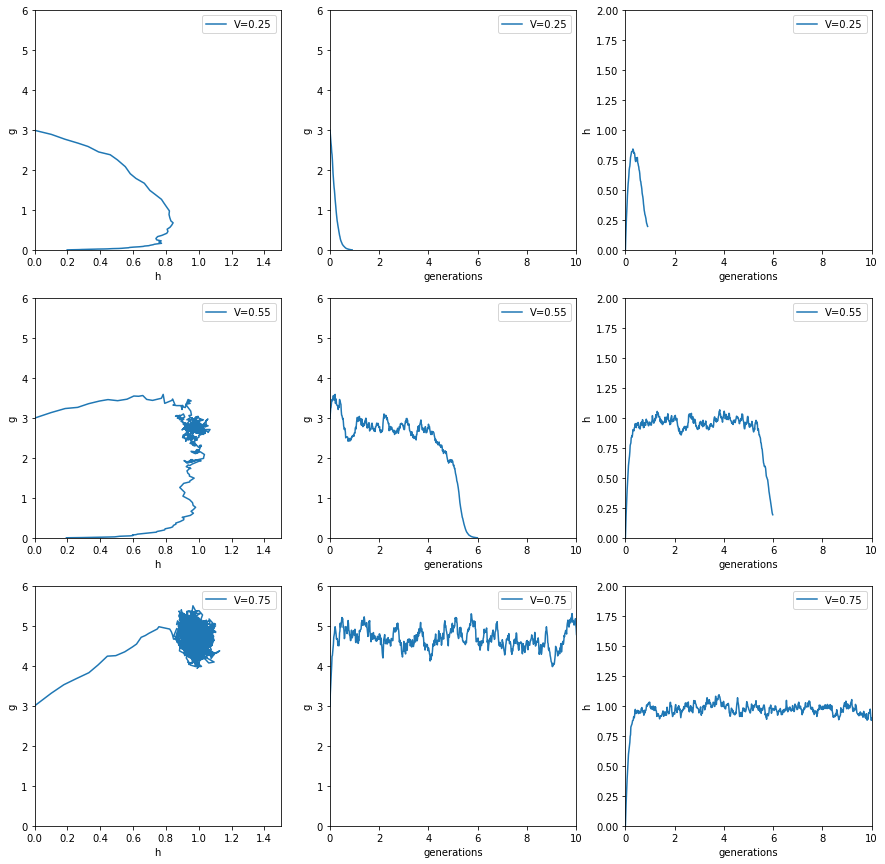

In [7]:
# example - running the TI model
fig, axs_ = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
for axs,V in zip(axs_,(.25,.55,.75)):
    state,hist,t=Simulation().run_TI(50,V,N=1,condition_end=0,g0=3,h0=0,save_hist=True)
    
    axs[0].plot(hist["h"],hist["g"],label="V=%.2f" % V)
    axs[1].plot(hist["t"]/sim_params.gen_length,hist["g"],label="V=%.2f" % V)
    axs[2].plot(hist["t"]/sim_params.gen_length,hist["h"],label="V=%.2f" % V)
    axs[0].set_xlabel("h")
    axs[0].set_ylabel("g")
    axs[1].set_xlabel("generations")
    axs[1].set_ylabel("g")
    axs[2].set_xlabel("generations")
    axs[2].set_ylabel("h")
    
    [ax.legend() for ax in axs]
    for ax in axs[1:]:
        ax.set_xlim([0,10])
    axs[1].set_ylim([0,6])
    axs[2].set_ylim([0,2])
    axs[0].set_ylim([0,6])
    axs[0].set_xlim([0,1.5])